In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
import os

import sys  

sys.path.insert(0, '../')

pd.set_option('display.max_columns', None)

from soundings.preprocessing import dataloader as dl
from soundings.deep_learning import mlutilities as ml
from soundings.experiments import results as results_calc
from soundings.plotting import results as results_plot

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
VOL = '/mnt/data1/stock/mlsoundings/results'

## Baseline Metrics

In [3]:
f = '/mnt/data1/stock/mlsoundings/preprocessed.npz'
container = np.load(f)
raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files'] # is this needed now?

(RAPtrain, RAPval, RAPtest,
 RTMAtrain, RTMAval, RTMAtest,
 GOEStrain, GOESval, GOEStest,
 RAOBtrain, RAOBval, RAOBtest) = ml.parition_all(rap=rap, raob=raob, goes=goes, rtma=rtma, 
                                                 percentages=(0.75,0.15,0.10), shuffle=False, seed=1234)

In [4]:
baseline = dict()

sets = ['train', 'val', 'test']

for i, (RAP, RAOB) in enumerate([(RAPtrain, RAOBtrain),
                                 (RAPval  , RAOBval),
                                 (RAPtest , RAOBtest)]):
    (rmse, mean_rmse, # temperature
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,1], RAOB[:, :, 1])
    baseline[f'rap_temperature_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_temperature_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse, #dewpoint
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,2], RAOB[:, :, 2])
    baseline[f'rap_dewpoint_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_dewpoint_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc

# Linear

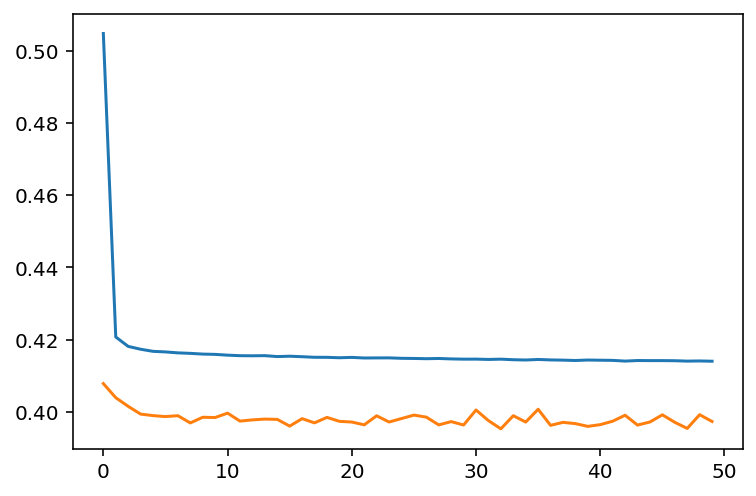

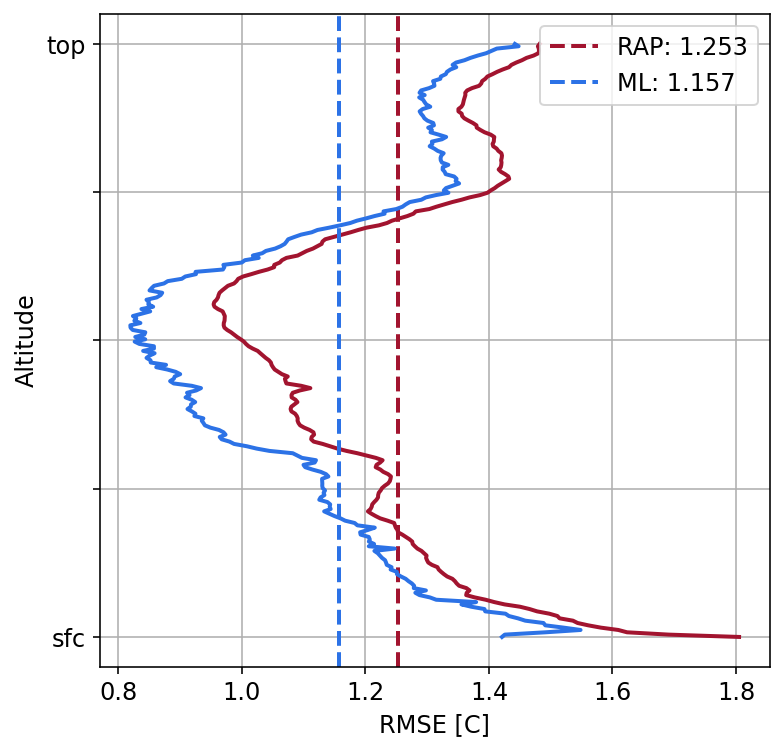

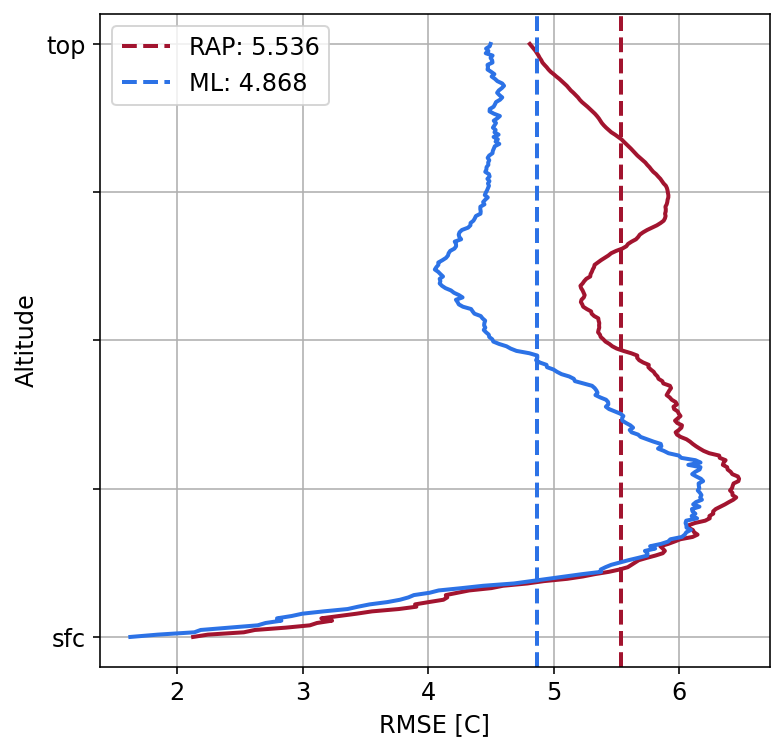

In [5]:
df = pd.read_csv(os.path.join(VOL, 'linear_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

# Fully Connected

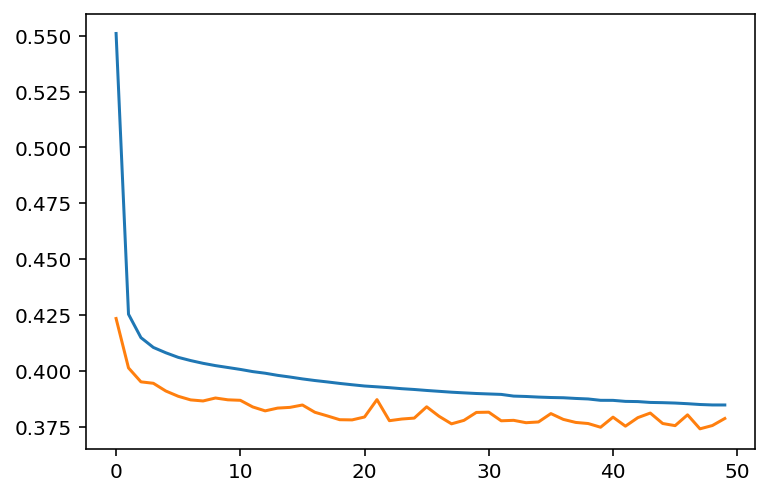

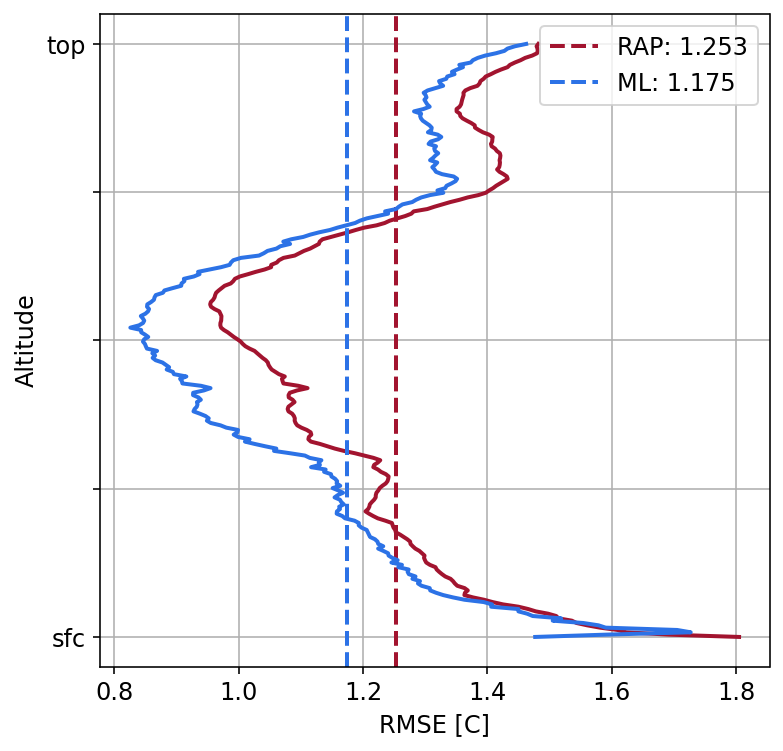

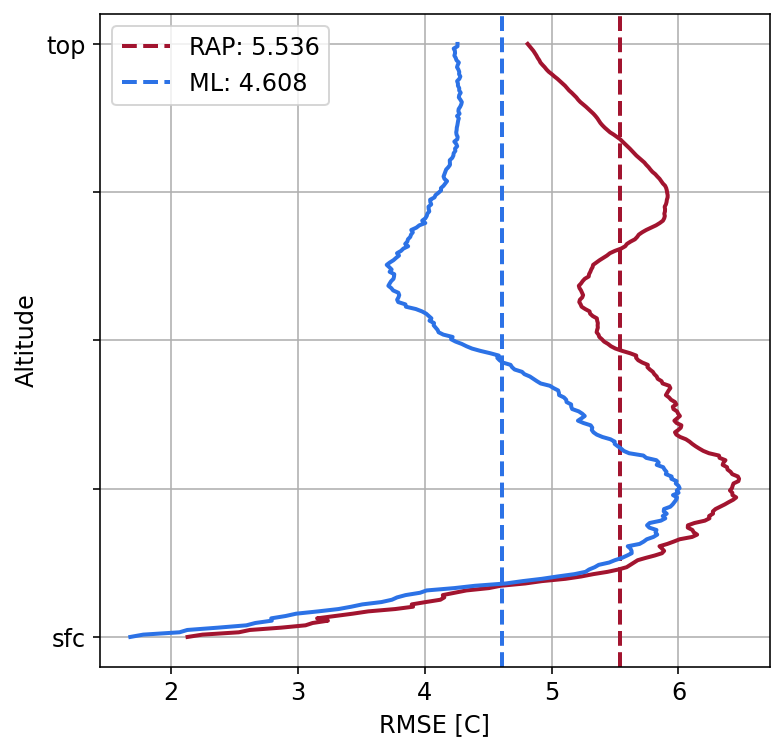

In [14]:
df = pd.read_csv(os.path.join(VOL, 'fully_connected_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

# Convolutional

In [50]:
df.sort_values(['ml_temperature_test_mean_rmse'])

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
2,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[4096, 4096]",512,"[64, 128, 256, 512, 512]","(5, 1)",relu,relu,adam,0.001,MAE,50,256,False,True,"[0.48091158270835876, 0.30104801058769226, 0.2...","[0.49494481086730957, 0.4184277653694153, 0.41...","[0.24497036635875702, 0.17508180439472198, 0.1...","[0.3277657926082611, 0.2643624246120453, 0.256...","[0.3248753249645233, 0.27539587020874023, 0.26...","[0.4118672311306, 0.3902885317802429, 0.391457...","[0.169634610414505, 0.15232513844966888, 0.153...","[0.27835971117019653, 0.2450355440378189, 0.24...","[1.855781002858729, 1.659093055848932, 1.70484...",1.390982,"[1.855781002858729, 1.659093055848932, 1.70484...",1.589637,"[2.034085094575594, 1.9731607178127346, 2.0796...",4.589191,"[2.034085094575594, 1.9731607178127346, 2.0796...",3.685755,"[1.7197620379676861, 1.6796884228224573, 1.690...",1.353157,"[1.7197620379676861, 1.6796884228224573, 1.690...",1.583758,"[2.061678842474371, 2.026860757796346, 2.17391...",4.678770,"[2.061678842474371, 2.026860757796346, 2.17391...",3.689975,"[2.0477784115419997, 2.0236302736310856, 2.131...",1.332475,"[2.0477784115419997, 2.0236302736310856, 2.131...",1.802174,"[2.714448092591022, 2.273192687924593, 2.48523...",4.659191,"[2.714448092591022, 2.273192687924593, 2.48523...",3.666449
0,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[4096, 4096]",512,"[64, 128, 256, 512, 512]","(3, 1)",relu,relu,adam,0.001,MAE,50,256,False,True,"[0.4878082871437073, 0.30606523156166077, 0.28...","[0.4929896295070648, 0.4186112880706787, 0.411...","[0.24303878843784332, 0.17523540556430817, 0.1...","[0.32620468735694885, 0.2649815082550049, 0.25...","[0.3121300935745239, 0.28608086705207825, 0.26...","[0.4078490138053894, 0.3956837058067322, 0.385...","[0.16634082794189453, 0.1565656065940857, 0.14...","[0.2602686882019043, 0.25197166204452515, 0.23...","[2.0761956532433787, 1.7517324536285204, 1.761...",1.321543,"[2.0761956532433787, 1.7517324536285204, 1.761...",1.494177,"[1.790611240879125, 1.8622020442581602, 1.9182...",4.525988,"[1.790611240879125, 1.8622020442581602, 1.9182...",3.572549,"[2.0508975874665945, 1.820085874622261, 1.7714...",1.252832,"[2.0508975874665945, 1.820085874622261, 1.7714...",1.479229,"[1.8923654479287824, 1.9228454532027608, 1.994...",4.599657,"[1.8923654479287824, 1.9228454532027608, 1.994...",3.575242,"[2.236635579819445, 2.1001498166571175, 2.1920...",1.347023,"[2.236635579819445, 2.1001498166571175, 2.1920...",1.794602,"[2.0465094266950503, 2.038641091331241, 2.2494...",4.607202,"[2.0465094266950503, 2.038641091331241, 2.2494...",3.518697
1,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[4096, 4096]",512,"[64, 128, 256, 512, 512]","(3, 1)",relu,relu,adam,0.001,MSE,50,256,False,True,"[0.4240458011627197, 0.21922799944877625, 0.20...","[0.4782857

In [12]:
df[(df['rtma_input_channels'] != '[]') &
   (df['goes_input_channels'] != '[]')]['ml_temperature_test_mean_rmse'].mean(), df[(df['rtma_input_channels'] != '[]') &
   (df['goes_input_channels'] == '[]')]['ml_temperature_test_mean_rmse'].mean()

(1.2524029170527664, 1.253639158460391)

In [11]:
df.iloc[df.sort_values(['ml_temperature_test_mean_rmse']).index[0]]['rtma_input_channels'] == '[]'

False

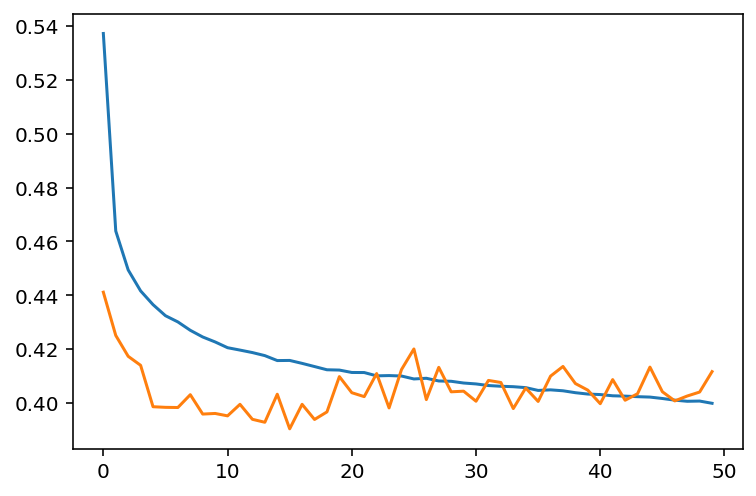

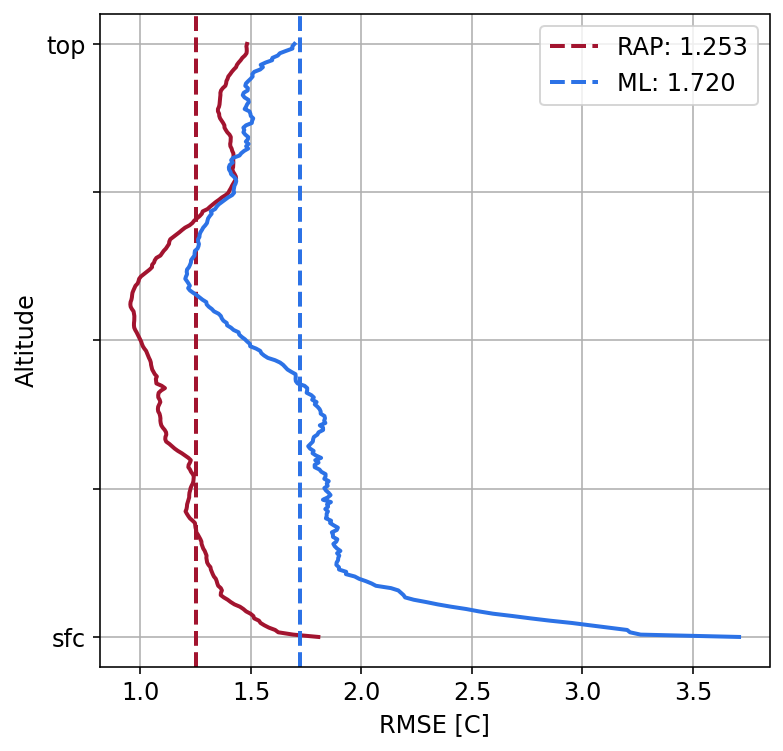

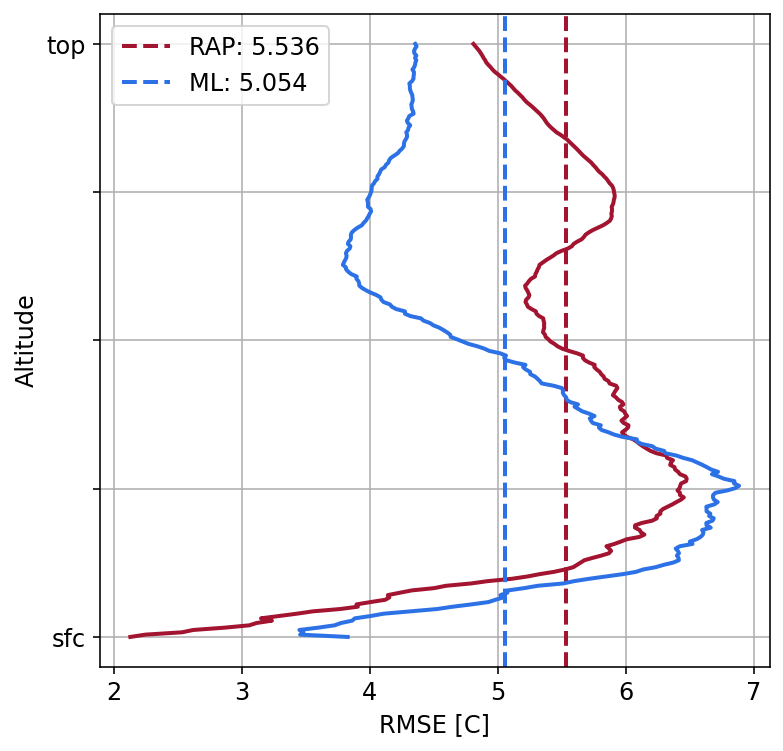

In [74]:
# df = pd.read_csv(os.path.join(VOL, 'multi_cnn_model_temperature_dewpoint.csv'))
df = pd.read_csv(os.path.join(VOL, 'multi_cnn_model_temperature_dewpoint_single.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [33]:
arr = np.asarray([literal_eval(arr) for arr in df['ml_temperature_test_rmse'].values])

In [58]:
df.iloc[np.argmin(arr[:,0])]

rap_input_dims                                                             [0, 1, 2, 3]
rap_output_dims                                                                  [1, 2]
rtma_input_channels                                                           [0, 1, 2]
goes_input_channels                                                                  []
n_rap_inputs                                                                   (256, 4)
n_im_inputs                                                                   (3, 3, 3)
hiddens                                                                      [256, 256]
n_network_outputs                                                                   512
n_units_in_conv_layers                                              [64, 128, 256, 512]
kernels_size_and_stride                                                          (5, 1)
rap_activation                                                                     tanh
dense_activation                

## Data Visualizations

In [40]:
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
df.head()

df['text'] = df['name'] + '<br>Population ' + (df['pop']/1e6).astype(str)+' million'
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
scale = 5000

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['lon'],
        lat = df_sub['lat'],
        marker = dict(
            size = df_sub['pop']/scale,
            color = colors[i],
            line_color = 'rgb(40,40,40)',
            line_width = 0.5,
            sizemode = 'area'
        )))

fig.update_layout(
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

fig.write_image('/home/stock/research/media/bubble_map.png', width=500, height=350, scale=3)

## Error Distribution by Month

In [54]:
import glob
import datetime

In [57]:
files = glob.glob('/mnt/data1/stock/mlsoundings/processed/*')

In [69]:
files[:20], months[:20]

(['/mnt/data1/stock/mlsoundings/processed/jan_2020_04_27_2301.nc',
  '/mnt/data1/stock/mlsoundings/processed/ilx_2019_05_15_2301.nc',
  '/mnt/data1/stock/mlsoundings/processed/ggw_2020_03_05_2305.nc',
  '/mnt/data1/stock/mlsoundings/processed/mfl_2020_04_27_1102.nc',
  '/mnt/data1/stock/mlsoundings/processed/shv_2019_10_09_1114.nc',
  '/mnt/data1/stock/mlsoundings/processed/boi_2020_02_19_2305.nc',
  '/mnt/data1/stock/mlsoundings/processed/eyw_2020_04_26_2303.nc',
  '/mnt/data1/stock/mlsoundings/processed/drt_2020_02_23_2305.nc',
  '/mnt/data1/stock/mlsoundings/processed/rev_2018_03_05_2310.nc',
  '/mnt/data1/stock/mlsoundings/processed/car_2017_01_18_1102.nc',
  '/mnt/data1/stock/mlsoundings/processed/bmx_2018_05_27_0503.nc',
  '/mnt/data1/stock/mlsoundings/processed/gjt_2019_07_29_1105.nc',
  '/mnt/data1/stock/mlsoundings/processed/jan_2018_05_21_2301.nc',
  '/mnt/data1/stock/mlsoundings/processed/chh_2019_07_25_1132.nc',
  '/mnt/data1/stock/mlsoundings/processed/riw_2018_02_05_1105.

In [68]:
months = np.zeros(len(files))
for i, f in enumerate(files):
    name = f.split('/')[-1]
    name = name[name.find('_')+1:-3]
    months[i] = datetime.datetime.strptime(name, '%Y_%m_%d_%H%M').month

In [ ]:
ind = Xtrain.shape[0]
months = np.zeros(len(Xtest))
# start at offset of Xtest
for i in range(len(Xtest)):
    f = valid_profile_files[ind + i]
    xar = xr.open_dataset(f)
    months[i] = datetime.datetime.strptime(str(xar.base_time.values)[:-3], '%Y-%m-%dT%H:%M:%S.%f').month
    xar.close()
    
    
total_rmse_l = np.zeros(len(Ttest))

for i in range(len(Xtest)):
    Y = nnet.use(Xtest[i:i+1, ...])
    T = Ttest[i:i+1]
    total_rmse_l[i] = ml.rmse(Y, T)
    
monthly_surface_err = []
monthly_total_err = []

for month in np.unique(months):
    monthly_surface_err.append(surface_err[months == month])
    monthly_total_err.append(total_rmse_l[months == month]
    
ind = np.abs(total_rmse_l - total_rmse_l.max()).argmin()
print(f'outlier at index: {ind} has error of: {total_rmse_l[ind]}') 
                             
plot_results(nnet, Xtest, Ttest, 1382, loss=False) #11, 17
                             
                             
radiosonde_plotting.plot_monthly_error(monthly_total_err, months, 'Entire Profile', file_name='../monthly_error');
                             
# remove outlier
monthly_total_err[6] = np.delete(monthly_total_err[6], 
                                 np.abs(monthly_total_err[6] - monthly_total_err[6].max()).argmin())